In [42]:
import torch
import torch.nn.functional as F
import math
import random
import numpy as np
from torchvision import datasets, transforms
import torch.nn as nn
from functorch import make_functional, vmap, jacrev

In [43]:
# Define 5-layer fully connected neural network with NTK parameterization

def _weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0, 1)


class FCNet(torch.nn.Module):
    def __init__(self, width):
        super(FCNet, self).__init__()
        self.width = width
        self.fc1 = nn.Linear(3072,width, bias=False)
        self.fc2 = nn.Linear(width,width, bias=False)
        self.fc3 = nn.Linear(width,width, bias=False)
        self.fc4 = nn.Linear(width,width, bias=False)
        self.fc5 = nn.Linear(width, 1, bias=False)
        self.apply(_weights_init)

    def forward(self, x):
        x = x.view(-1, 3072)       
        x = 1/math.sqrt(3072)*self.fc1(x)
        x = F.relu(x)
        x = 1/math.sqrt(self.width)*self.fc2(x)
        x = F.relu(x)
        x = 1/math.sqrt(self.width)*self.fc3(x)
        x = F.relu(x)
        x = 1/math.sqrt(self.width)*self.fc4(x)
        x = F.relu(x)
        x = 1/math.sqrt(self.width)*self.fc5(x)
        return x

In [44]:
# Set random seed

seed = 888
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda:0")

In [45]:
# Load CIFAR 10 dataset with class 7 and 9

Id = 6
train_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

        
trainset = datasets.CIFAR10(root='../../../cifar10', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='../../../cifar10', train=False, download=True, transform=transform)


idx = [i for i,x in enumerate(trainset.targets) if x == Id or x==Id+2]    
trainset.targets = [trainset.targets[i]-Id-1 for i in idx][0:train_size]
trainset.data = [trainset.data[i] for i in idx][0:train_size]

print("size of training set is : "+str(len(trainset.targets)))



train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=train_size, shuffle= False)  
train_batch_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=32, shuffle= True)  

Files already downloaded and verified
Files already downloaded and verified
size of training set is : 128


In [46]:
# Compute NTK and decompose the full training loss into the top eigendirection of NTK

def loss_decomposition(model):
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device).view(-1,1).float()
            output = model(data)
            optimizer.zero_grad()
            fnet, params = make_functional(model)
            ntk = empirical_ntk_jacobian_contraction(fnet_single, params, data, data).squeeze(3).squeeze(2).detach()
            U,S,V = torch.svd(ntk)
            project = torch.abs((output-target).t()@U)**2/train_size
            top_loss = torch.sum(project[0][:1])
            loss = F.mse_loss(output, target)
        return loss.item(), top_loss.item()

In [47]:
model = FCNet(width = 1024).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=6.0)

# Define functions (functorch) to compute NTK (Neural Tangent Kernel)

fnet, params = make_functional(model)
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)

def empirical_ntk_jacobian_contraction(fnet_single, params, x1, x2):
    # Compute J(x1)
    jac1 = torch.vmap(torch.func.jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]

    # Compute J(x2)
    jac2 = torch.vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]
    
    # Compute J(x1) @ J(x2).T
    result = torch.stack([torch.einsum('Naf,Mbf->NMab', j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result

In [48]:
epoch = 50
train_losses = []
top_losses = []
remaining_losses = []
sgd_step = 1

In [49]:
for i in range(1,epoch+1):
        for batch_idx, (data, target) in enumerate(train_batch_loader):
            data, target = data.to(device), target.to(device).view(-1,1).float()
            output = model(data)
            optimizer.zero_grad()
            
            train_loss, top_loss = loss_decomposition(model)
            
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
            print(f'SGD step:{sgd_step}, training loss:{loss.item()}')
            sgd_step += 1
            train_losses.append(train_loss)
            top_losses.append(top_loss)
            remaining_losses.append(train_loss - top_loss)

SGD step:1, training loss:1.1141245365142822
SGD step:2, training loss:0.7984484434127808
SGD step:3, training loss:0.7165209054946899
SGD step:4, training loss:0.4853658974170685
SGD step:5, training loss:0.3411206007003784
SGD step:6, training loss:0.3927733898162842
SGD step:7, training loss:0.5473995208740234
SGD step:8, training loss:0.38175976276397705
SGD step:9, training loss:0.37246108055114746
SGD step:10, training loss:0.4820495843887329
SGD step:11, training loss:0.685820460319519
SGD step:12, training loss:1.0712356567382812
SGD step:13, training loss:0.8815684914588928
SGD step:14, training loss:0.7099966406822205
SGD step:15, training loss:0.6996430158615112
SGD step:16, training loss:0.44016990065574646
SGD step:17, training loss:0.2352011501789093
SGD step:18, training loss:0.18054866790771484
SGD step:19, training loss:0.22603555023670197
SGD step:20, training loss:0.13589388132095337
SGD step:21, training loss:0.14626523852348328
SGD step:22, training loss:0.13003318

SGD step:176, training loss:0.004706384148448706
SGD step:177, training loss:0.00703909806907177
SGD step:178, training loss:0.006002721842378378
SGD step:179, training loss:0.004976257216185331
SGD step:180, training loss:0.004414119757711887
SGD step:181, training loss:0.004903153516352177
SGD step:182, training loss:0.001873853150755167
SGD step:183, training loss:0.0025387294590473175
SGD step:184, training loss:0.004523478448390961
SGD step:185, training loss:0.0032758833840489388
SGD step:186, training loss:0.0027900408022105694
SGD step:187, training loss:0.0035871637519448996
SGD step:188, training loss:0.0020547613967210054
SGD step:189, training loss:0.0025279633700847626
SGD step:190, training loss:0.0039391596801579
SGD step:191, training loss:0.0014915496576577425
SGD step:192, training loss:0.0028938644099980593
SGD step:193, training loss:0.0025073415599763393
SGD step:194, training loss:0.002199142472818494
SGD step:195, training loss:0.0010039974004030228
SGD step:196,

In [50]:
import matplotlib.pyplot as plt

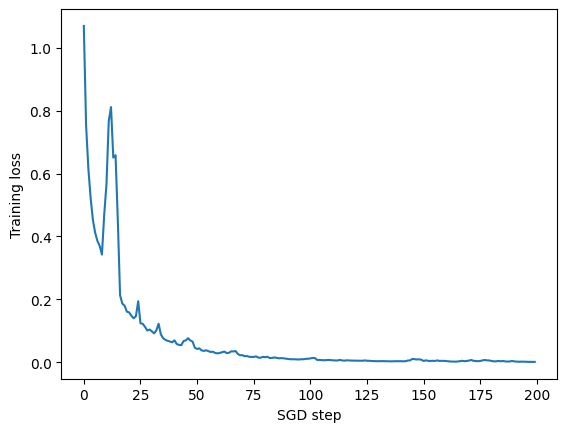

In [51]:
# Plot the total training loss

plt.plot(train_losses)
plt.xlabel('SGD step')
plt.ylabel('Training loss')
plt.show()

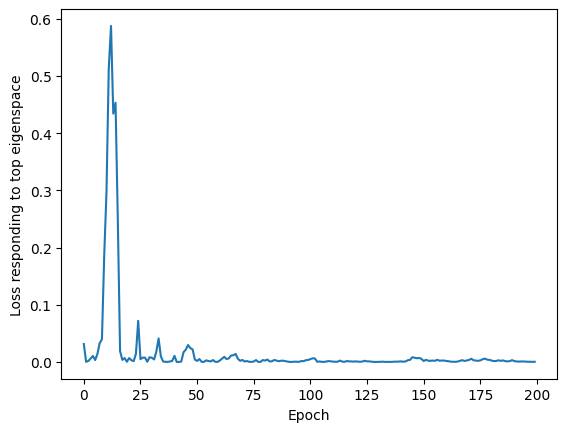

In [52]:
# Plot the loss corresponding to top eigendirection of NTK

plt.plot(top_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss responding to top eigenspace')
plt.show()

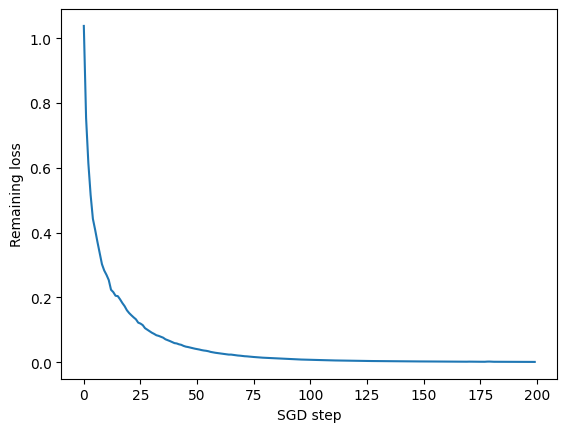

In [53]:
# Plot the loss corresponding to remaining (2nd - ) eigendirections of NTK

plt.plot(remaining_losses)
plt.xlabel('SGD step')
plt.ylabel('Remaining loss')
plt.show()